Link to Perceptron Implementation:

https://github.com/jiffylesica/jiffylesica.github.io/blob/f3386b4f18d6acdffbc6182d1e5081c1bd403d10/posts/Implementing%20Perceptron/perceptron.py

# Implementing the Perceptron Algorithm:

### By Jiffy Lesica

## Abstract:
 
This blog post demonstrates an implementation and evaluation of the perceptron algorithm. It walks through the coding of a perceptron class, which inherits and extends functionality of a LinearModel class. This implementation includes the calculation of data sample score, and gradient descent updates to a weight vector. Following this implementation, the blog post validates the source code by performing experiments on both linearly separable and non-separable datasets. Additionally, it explores the effect of modifying the algorithm to allow for minibatch updates, and analyzes runtime complexities, offering a comprehensive view of how these factors impact convergence and overall performance.

In [12]:
import torch

In [13]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In the perceptron.py source code, I have implemented a Perceptron class. Of not is the gradient descent function - grad() - which performs gradient descent on the data contained in our instance of the Perceptron model:

Step 1: Score Computation - The function computes a score for each data point in X by performing matrix multiplication between the feature matrix - X - and the weight vector - self.w.

```python
score = X @ self.w
```

Step 2: Update labels - since the perceptron update requires labels of -1 or 1, the function converts the binary labels y (currently 0 or 1) to these values.

```python
y_ = 2 * y - 1
```

Step 3: Identify misclassifications - for each data point, the function checks if the product of the new label - -1 or 1 - and the data points score is negative. If it is negative, this means that there is a misclassification. Since the perceptron algorithm thresholds scores at 0 - i.e. positive scores are classified as positive predictions, and negative scores as negative predictions - a negative product between target value and score indicates a misalignment between the two.

```python
misclassified = 1.0 * (y_ * score < 0).float()
```

Step 4: Reshaping for Multiplication - both our target value vector and misclassified vector are reshaped into column vectors to allow for multiplication in the perceptron update (technical code, not essential to math of function)

Step 5: Compute the update - the update term - which is returned to the step function which actually updates the perceptron weight vector - is calculated as the mean over all datapoints of X which have been evaluated for misclassification, allowing us to subtract the gradient in the optimizer's step function.

```python
return torch.mean((- (misclassified * y_) * X), dim=0)
```

Put together, this results in the full grad() function:

```python
def grad(self, X, y):
        score = X @ self.w
        y_ = 2 * y - 1
        misclassified = 1.0 * (y_ * score < 0).float()
        # Had to reshape both to [300,1] tensors to multiply
        # https://pytorch.org/docs/stable/generated/torch.Tensor.reshape.html
        misclassified = misclassified.reshape(misclassified.shape[0], 1)
        y_ = y_.reshape(y_.shape[0], 1)


        # Return update
        return torch.mean((- (misclassified * y_) * X), dim = 0)
```


In [28]:
# Code which helps visualize the dimensionality of tensors used in grad function
test_X = torch.tensor([
    [2.0, -1.0, 0.5],
    [1.0, -2.0, 1.5],
    [3.0, 0.0, -0.5]
])
print("test_X")
print(test_X)
print(test_X.shape, end="\n\n")

test_w = torch.tensor([0.5, 0.5, 0.5]) 
print("test_w")
print(test_w)
print(test_w.shape, end="\n\n")

test_y = torch.tensor([1.0, 1.0, 0.0]) 
print("test_y")
print(test_y)
print(test_y.shape, end="\n\n")

scores = test_X @ test_y
print("scores")
print(scores)
print(scores.shape, end="\n\n")

test_y_ = 2 * test_y - 1  
print("test_y_")
print(test_y_)
print(test_y_.shape, end="\n\n")

misclassified = 1.0 * (test_y_ * scores < 0).float()
print("misclassified")
print(misclassified)
print(misclassified.shape, end="\n\n")

out_tensor = - (misclassified * test_y_) * test_X
print("out_tensor")
print(out_tensor)
print(out_tensor.shape, end="\n\n")

mean_test = torch.mean(out_tensor, dim=0) # Seems dim = 0 is column-wise, dim = 1 is row
print("mean_test")
print(mean_test)
print(mean_test.shape)

test_X
tensor([[ 2.0000, -1.0000,  0.5000],
        [ 1.0000, -2.0000,  1.5000],
        [ 3.0000,  0.0000, -0.5000]])
torch.Size([3, 3])

test_w
tensor([0.5000, 0.5000, 0.5000])
torch.Size([3])

test_y
tensor([1., 1., 0.])
torch.Size([3])

scores
tensor([ 1., -1.,  3.])
torch.Size([3])

test_y_
tensor([ 1.,  1., -1.])
torch.Size([3])

misclassified
tensor([0., 1., 1.])
torch.Size([3])

out_tensor
tensor([[-0.0000,  1.0000,  0.5000],
        [-0.0000,  2.0000,  1.5000],
        [-0.0000, -0.0000, -0.5000]])
torch.Size([3, 3])

mean_test
tensor([0.0000, 1.0000, 0.5000])
torch.Size([3])


In [15]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2): 
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y


def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = 2*y[ix]-1, facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)


In [ ]:
def perceptron_loss_and_plot(X, y, k_choice = 5):
    # Generate 2d data

    # Instantiate the model and optimizer
    p = Perceptron()
    opt = PerceptronOptimizer(p)

    # Training loop
    loss_vec = []
    # Set max iterations to avoid infinite loop in nonseparable cases
    max_iterations = 1000 
    iteration = 0
    loss = p.loss(X, y)

    while loss > 0 and iteration < max_iterations:
        loss = p.loss(X, y)
        loss_vec.append(loss.item())
        k = k_choice
        idx = torch.randperm(X.size(0))[:k]
        X_pass = X[idx, :]
        y_pass = y[idx]
        opt.step(X_pass, y_pass)
        iteration += 1

    print("Final Loss:", loss.item(), "after", iteration, "iterations.")

    # Plot loss per point
    plt.figure()
    plt.plot(loss_vec, color = "slategrey")
    plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
    plt.xlabel("Perceptron Iteration (Updates Only)")
    plt.ylabel("loss")
    
    if X.shape[1] <= 3:
        # Data with separating line
        fig, ax = plt.subplots(1, 1, figsize = (4, 4))
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        plot_perceptron_data(X, y, ax)
        draw_line(p.w, -1, 2, ax, color = "black")
        plt.show()

## Experiments

### Experiment 1: Generate a linearly separable, 2D dataset, and show that the perceptron algorithm converges to weight vector tha describes a separating line (i.e. achieves loss of 0)

Final Loss: 0.0 after 180 iterations.


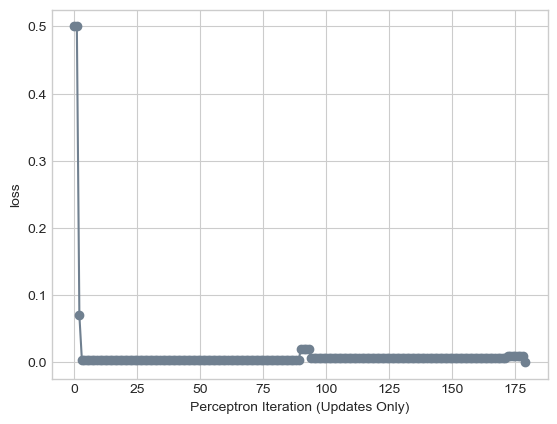

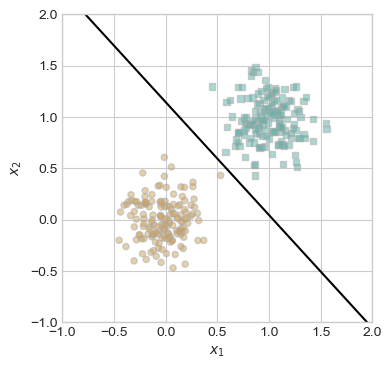

In [17]:
'''
Maintaining low noise - and thus low standard deviation of data - produces linearly separable data
'''

X, y = perceptron_data(n_points=300, noise=0.2, p_dims=2)
perceptron_loss_and_plot(X, y)

*Below visualization comes from Prof. Phil Chodrow's Machine Learning Course, Lecture 7 - Introduction to Classification: The Perceptron (Subsection: **A Complete Run**)*

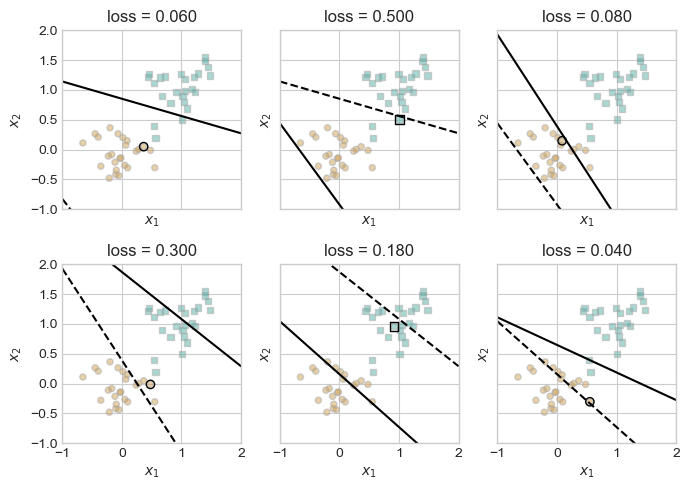

In [18]:
torch.manual_seed(1234)
X, y = perceptron_data(n_points = 50, noise = 0.3)
n= X.shape[0]
# initialize a perceptron 
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(2, 3, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0 and current_ax < 6:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 

    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = p.loss(x_i, y_i).item()

    if local_loss > 0:
        opt.step(x_i, y_i)
    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[2*(y[i].item())-1]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

### Experiment 2: Generate a non-linearly separable, 2D dataset, and show that the perceptron algorithm does not converge on a final weight vector (i.e. does not achieve loss of 0). Instead, it runs max iterations without achieving perfect accuracy.

Final Loss: 0.03333333507180214 after 1000 iterations.


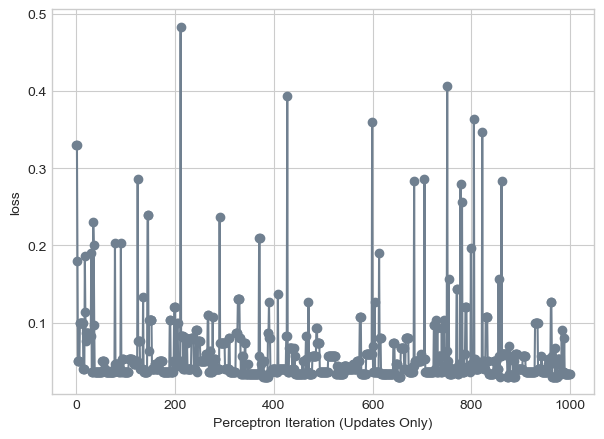

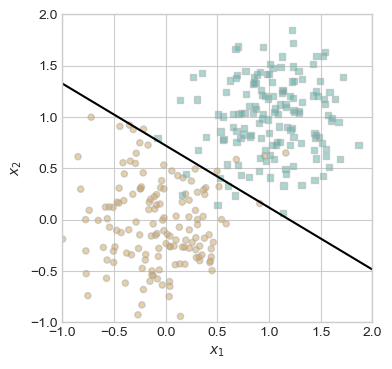

In [19]:
'''
By increasing the noise parameter, we increase the standard deviation of the data points of a class.
This leads to more overlap across elements with different target values, increasing the likelihood
of non-linearly separable data
'''
X, y = perceptron_data(n_points=300, noise=0.4, p_dims=2)
perceptron_loss_and_plot(X, y)

### Experiment 3: Show that the perceptron algorithm can run on data with at least 5 features, and visualize the evolution of the loss score over the raining period.

Final Loss: 0.0 after 46 iterations.


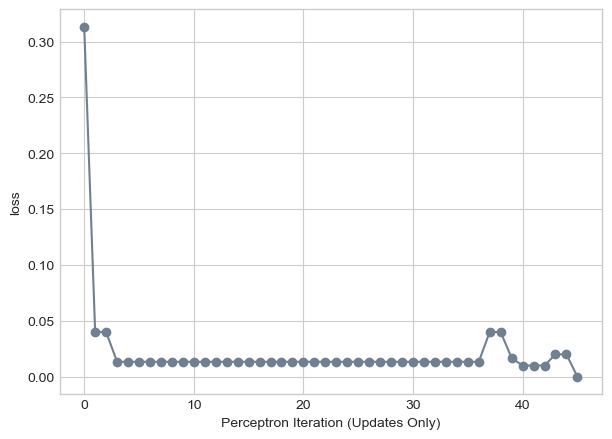

In [20]:
'''
Adjusting p_dims parameters allows us to modify number of features in data. 
p_dims = 5 corresponds to 5 features.
'''
X, y = perceptron_data(n_points=300, noise=0.4, p_dims=5)
perceptron_loss_and_plot(X, y)

*Note: This 5-feature data is linearly separable as the loss reaches 0.0!*

## Minibatch Perceptron Experiments:

In [21]:
X, y = perceptron_data(n_points=300, noise=0.2, p_dims=2)

### Minibatch Experiment 1: Test with a single sample to show that minibatch behaves like standard perceptron

Final Loss: 0.0 after 24 iterations.


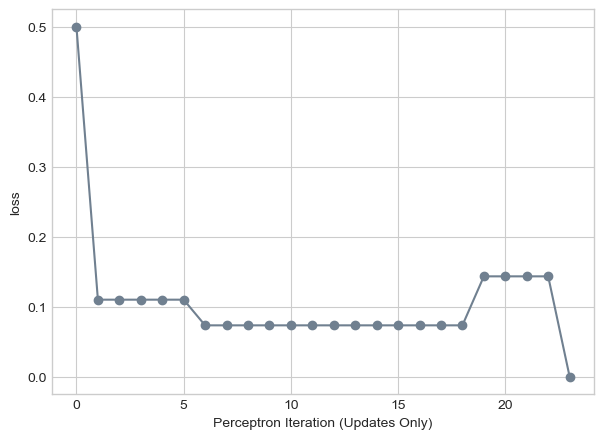

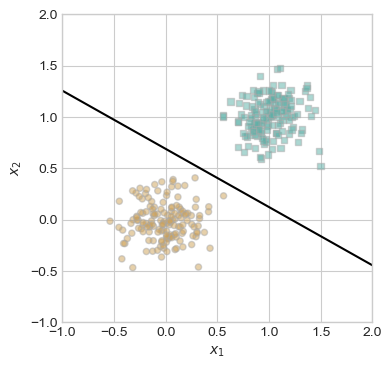

In [22]:
perceptron_loss_and_plot(X, y, k_choice=1)

*When passing a batch size of 1 sample to the minibatch version of our algorithm, our implementation still behaves like a standard perceptron, performing gradient descent over one data point at a time.*

### Minibatch Experiment 1: Test with a multiple samples - a small batch - to show that minibatch can still find separating line on 2D data

Final Loss: 0.0 after 9 iterations.


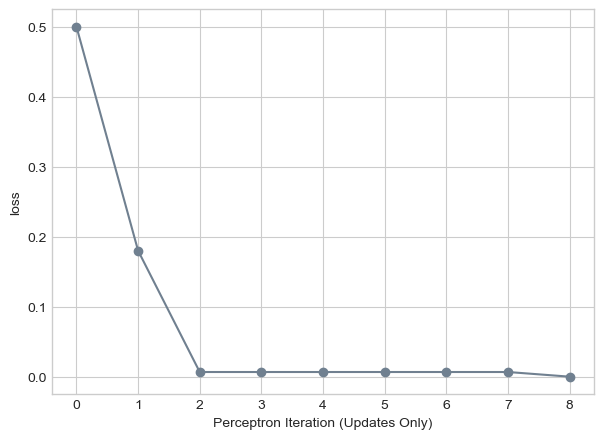

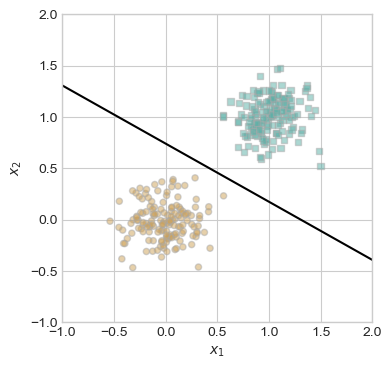

In [23]:
perceptron_loss_and_plot(X, y, k_choice=10)

*Even though each step of the perceptron algorithm performs computations on multiple data points, the minibatch algorithm can still find a separating line on linearly separable data, as shown by it achieving a final loss of 0.0*

### Minibatch Experiment 1: Test with full dataset as batch - size of the batch is the number of samples in dataset - to show that minibatch can still converge even when data isn't perfectly separable.

Final Loss: 0.02666666731238365 after 1000 iterations.


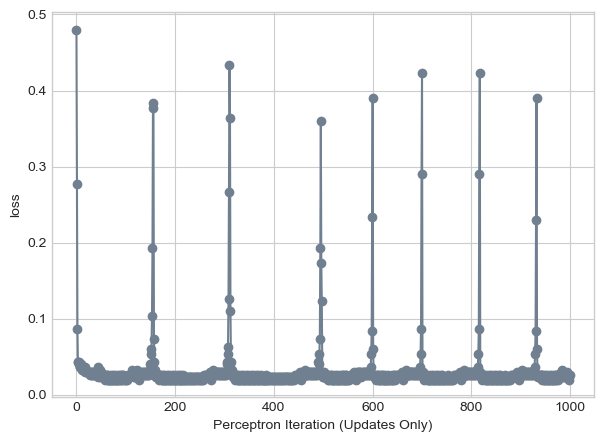

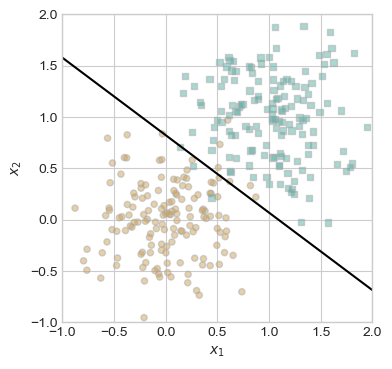

In [24]:
X, y = perceptron_data(n_points=300, noise=0.4, p_dims=2)
perceptron_loss_and_plot(X, y, k_choice=X.shape[0])

## Runtime complexity of standard perceptron single iteration

A single iteration of the standard perceptron algorithm performs operations on only a single data point. So, runtime complexity will be dependent on the number of features which it is matrix multiplied with during score calculation and the update of the weight vector. Thus, for an input with k features, the standard perceptron single iteration runtime is O(k).

## Runtime of Minibatch perceptron

The runtime of the Minibatch perceptron has an upper bound complexity limit of O(n x k), where n is the number of samples operated on in an iteration, and k is again the number of features. Since we have shown in our experiments above that the minibatch can still converge when the batch size equals the number of samples in a data set of length n, n x p is the upper bounded complexity of a single iteration of the Minbatch algorithm.

## Conclusion:

In summary, the experiments confirm that the perceptron algorithm correctly converges on linearly separable data while revealing its limitations on non-linearly separable datasets. The analysis of runtime complexities shows that a standard perceptron iteration operates in O(k) time, while a minibatch implementation of the perceptron algorithm has an upper complexity bound of O(n × k). This exploration provides insights into how feature/weight-vector optimization can enhance our ability to classify data. 